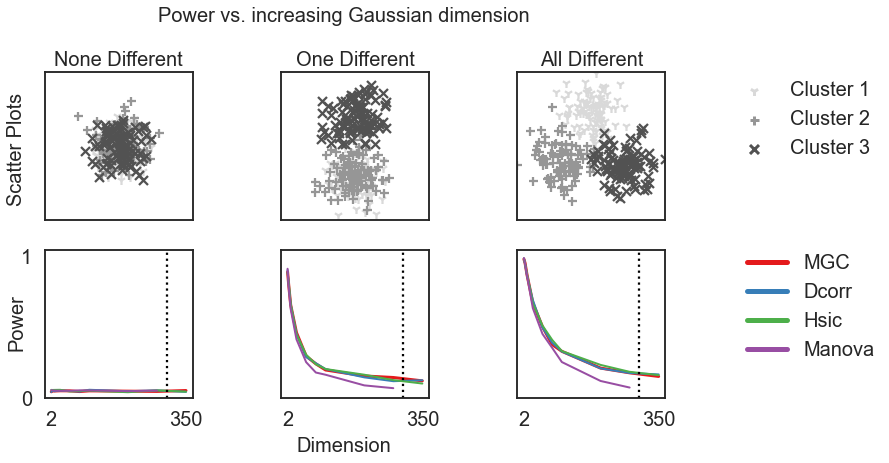

In [1]:
#!/usr/bin/env python
# coding: utf-8

# # 3 Sample Tests Power over Increasing Dimension

# These are same useful functions to import. Since we are calculating the statistical power over all the tests for all the simulations, we can just use a wild card import from the respective modules

# In[1]:


import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from hyppo.independence import MGC, Dcorr, Hsic
from hyppo.sims import gaussian_3samp
from joblib import Parallel, delayed
from matplotlib.legend import Legend

from power_3samp import power_3samp_epsweight

sys.path.append(os.path.realpath(".."))


# In[4]:


import seaborn as sns

sns.set(color_codes=True, style="white", context="talk", font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])


# In[5]:


# from statsmodels.multivariate.manova import MANOVA


# class PyManova:
#     r"""
#     Wrapper of statsmodels MANOVA
#     """

#     def _statistic(self, x, y):
#         r"""
#         Helper function to calculate the test statistic
#         """
#         stat = MANOVA(x, y).mv_test().results['x0']['stat'].values[1, 0]
#         self.stat = stat

#         return stat


# In[6]:


from rpy2.robjects import Formula, numpy2ri
from rpy2.robjects.packages import importr


class Manova:
    r"""
    Wrapper of R MANOVA
    """

    def __init__(self):
        self.stats = importr("stats")
        self.r_base = importr("base")

        numpy2ri.activate()

        self.formula = Formula("X ~ Y")
        self.env = self.formula.environment

    def statistic(self, x, y):
        r"""
        Helper function to calculate the test statistic
        """
        self.env["Y"] = y
        self.env["X"] = x

        stat = self.r_base.summary(self.stats.manova(self.formula), test="Pillai")[3][4]

        return stat


# These are some constants that are used in this notebook. If running these notebook, please only manipulate these constants if you are not running more tests. They define the epsilons (distance from 0 for the center of each gaussian cluster) tested upon and the number of replications. The simulations tested over and the independence tests tested over are defined also.

# In[7]:

NAME = "3samp_vs_dim"
STEP_SIZE = 0.05
EPSILON1 = 0.5  # 0.6
DIMENSIONS = [2, 5, 10, 25, 50, 75, 100, 200, 275, 350]
POWER_REPS = 5
REPS = 1000
n_jobs = 5
workers = 5
ONEWAY_EPSILON = 0.3

FONTSIZE = 12

run = False  # True#
plot = True  # False#

# In[8]:


tests = [
    MGC,
    Dcorr,
    Hsic,
    # PyManova,
    Manova,
]

multiway_tests = [
    # Dcorr,
    # MGC,
]

cases = [
    1,
    2,
    3,
    # 4,
    # 5,
    # 6,
]

multiway_cases = [
    # 1,
    # 6,
]


# The following function calculates the estimated power ``POWER_REPS`` number off times and averages them. It does this iterating over the number of sample sizes.
#
# **Note: We only recommend running this code if running the next 2 cells ONCE to generate the csv files used to visualize the plots. This code takes a very long time to run and if running, we recommend using a machine with many cores.**

# In[ ]:


def estimate_power(case, test, multiway=False):
    if test == Manova:
        ws = 1
        dimensions = DIMENSIONS[:-2]
    else:
        ws = workers
        dimensions = DIMENSIONS

    est_power = np.array(
        [
            np.mean(
                [
                    power_3samp_epsweight(
                        test,
                        case=case,
                        epsilon=EPSILON1,
                        workers=ws,
                        d=d,
                        c=ONEWAY_EPSILON,
                        multiway=multiway,
                        reps=REPS,
                    )
                    for _ in range(POWER_REPS)
                ]
            )
            for d in dimensions
        ]
    )

    if not os.path.exists(f"../ksample/{NAME}/"):
        os.makedirs(f"../ksample/{NAME}/")
    if multiway:
        np.savetxt(
            "../ksample/{}/{}_{}_multiway.csv".format(NAME, case, test.__name__),
            est_power,
            delimiter=",",
        )
    else:
        np.savetxt(
            "../ksample/{}/{}_{}.csv".format(NAME, case, test.__name__),
            est_power,
            delimiter=",",
        )
    return est_power


# In[ ]:

if run:
    outputs = Parallel(n_jobs=n_jobs, verbose=100)(
        [delayed(estimate_power)(case, test) for case in cases for test in tests]
    )

    outputs = Parallel(n_jobs=n_jobs, verbose=100)(
        [
            delayed(estimate_power)(case, test, multiway=True)
            for case in multiway_cases
            for test in multiway_tests
        ]
    )


# The following code loops over each saved independence test file and generates absolute power curves for each test and for each simulation modality.

# In[9]:


FONTSIZE = 20


def plot_power():
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

    sim_title = [
        "None Different",
        "One Different",
        "All Different",
        # "More Different",
    ]

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            case = sorted(list(set(cases + multiway_cases)))[j]
            if i == 0:
                sims = gaussian_3samp(100, epsilon=4, weight=0.9, case=case)

                sim_markers = ["1", "+", "x"]
                custom_color = ["#d9d9d9", "#969696", "#525252"]

                count = 0
                scatters = []
                for sim in sims:
                    x, y = np.hsplit(sim, 2)
                    scatters.append(
                        col.scatter(
                            x, y, marker=sim_markers[count], color=custom_color[count]
                        )
                    )

                    if case not in [6]:
                        col.set_xlim(-5, 5)
                    if case not in [2, 4, 6]:
                        col.set_ylim(-5, 5)
                    else:
                        col.set_ylim(-3, 7)
                    col.set_xticks([])
                    col.set_yticks([])
                    col.set_title(sim_title[j], fontsize=FONTSIZE)
                    count += 1
            else:
                for test in tests:
                    custom_color = {
                        "Dcorr": "#377eb8",
                        "Hsic": "#4daf4a",
                        "MGC": "#e41a1c",
                    }
                    for multiway in [False, True]:
                        if multiway and (
                            test not in multiway_tests or case not in multiway_cases
                        ):
                            continue
                        elif multiway:
                            power = np.genfromtxt(
                                "../ksample/{}/{}_{}_multiway.csv".format(
                                    NAME, case, test.__name__
                                ),
                                delimiter=",",
                            )
                            ls = "--"
                            label = f"Multiway {test.__name__}"
                        else:
                            power = np.genfromtxt(
                                "../ksample/{}/{}_{}.csv".format(
                                    NAME, case, test.__name__
                                ),
                                delimiter=",",
                            )
                            ls = "-"
                            label = test.__name__

                        if test.__name__ in custom_color.keys():
                            if test.__name__ == "MGC":
                                col.plot(
                                    DIMENSIONS[: len(power)],
                                    power,
                                    custom_color[test.__name__],
                                    label=label,
                                    lw=3,
                                    ls=ls,
                                )
                            else:
                                col.plot(
                                    DIMENSIONS[: len(power)],
                                    power,
                                    custom_color[test.__name__],
                                    label=label,
                                    lw=2,
                                    ls=ls,
                                )
                        else:
                            col.plot(
                                DIMENSIONS[: len(power)],
                                power,
                                label=label,
                                lw=2,
                                ls=ls,
                            )
                        col.tick_params(labelsize=FONTSIZE)
                        col.set_xticks([DIMENSIONS[0], DIMENSIONS[-1]])
                        col.set_ylim(0, 1.05)
                        col.set_yticks([])
                        if j == 0:
                            col.set_yticks([0, 1])
            col.set_aspect(np.diff(col.get_xlim()) / np.diff(col.get_ylim()))
            col.axvline(300, ls=":", c="black")

    fig.text(0.5, 0, "Dimension", ha="center", fontsize=FONTSIZE)
    #     fig.text(0.75, 0, 'Increasing Weight', ha='center')
    fig.text(0.11, 0.3, "Power", va="center", rotation="vertical", fontsize=FONTSIZE)
    fig.text(
        0.11, 0.7, "Scatter Plots", va="center", rotation="vertical", fontsize=FONTSIZE
    )

    leg = plt.legend(
        bbox_to_anchor=(1.04, 0.5),
        bbox_transform=plt.gcf().transFigure,
        ncol=1,
        loc="upper center",
        fontsize=FONTSIZE,
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=0.20)
    leg = Legend(
        fig,
        scatters,
        ["Cluster 1", "Cluster 2", "Cluster 3"],
        loc="upper center",
        frameon=False,
        ncol=1,
        bbox_transform=plt.gcf().transFigure,
        bbox_to_anchor=(1.03, 0.9),
        fontsize=FONTSIZE,
    )
    fig.add_artist(leg)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)
    plt.suptitle("Power vs. increasing Gaussian dimension", fontsize=FONTSIZE, y=1.03)
    # plt.savefig(f'../ksample/figs/{NAME}.pdf', transparent=True, bbox_inches='tight')


if plot:
    plot_power()

# In[10]:


# In[ ]:
